# Andrew Yang's Freedom Dividend: Find revenue-neutral parameters

Estimate the effect of Andrew Yang's [Freedom Dividend](https://www.yang2020.com/policies/the-freedom-dividend/) of $12,000 per year per adult over age 18, funded by a 10 percent [value-added tax](https://www.yang2020.com/policies/value-added-tax/) and reducing benefits by up to the UBI amount for each tax unit.

Assumptions:
* Adults are 18+ not 19+, for data availability.
* Benefits include SNAP, WIC, SSI, TANF, WIC, Social Security, and unemployment insurance. Per Yang's [tweet](https://twitter.com/AndrewYang/status/970104619832659968), it excludes housing benefits and Medicare. It also excludes Medicaid, veteran's benefits (which are largely pension and healthcare) and "other benefits" included in C-TAM, which also include some healthcare.
* VAT incidence is proportional to [Tax Policy Center's estimate](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat) of a 5 percent VAT's effect as of 2015. These are scaled linearly to match Yang's estimate that his VAT would raise $800 billion per year.
* VAT incidence is treated as an income tax; per TPC:
>Conceptually, the tax can either raise the total price (inclusive of the sales tax) paid by consumers or reduce the amount of business revenue available to compensate workers and investors. Theory and evidence suggest that the VAT is passed along to consumers via higher prices. Either way, the decline in real household income is the same regardless of whether prices rise (holding nominal incomes constant) or whether nominal incomes fall (holding the price level constant).

*Data: CPS  |  Tax year: 2019  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'2.0.1'

### Settings

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

GRID_COLOR = '#f5f5f5'

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

In [6]:
np.random.seed(0)

## Major parameters

In [7]:
UBI = 1000 * 12
TOTAL_VAT = 800e9
TOTAL_FTT = 50e9
CARBON_FEE = 40
CARBON_FEE_TPC = 49  # Fee from the paper.
CARBON_FEE_UBI_SHARE = 0.5  # Half goes to UBI, half to other projects.
PCT_CITIZEN = 0.93

In [8]:
INCIDENCE = pd.DataFrame({
    'income_percentile_floor': [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99, 99.9],
    'vat': [3.9, 3.9, 3.6, 3.6, 3.6, 3.6, 3.6, 3.4, 3.4, 3.2, 2.8, 2.5, 2.5],
    'carbon_tax': [0.8, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.8, 1.8, 1.8, 1.6, 1.4, 0.7],
    'ftt': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.3, 0.4, 0.8, 1.0]
})

INCIDENCE[['vat', 'carbon_tax', 'ftt']] /= 100

# Adjust carbon tax by the relative fee schedule.
INCIDENCE.carbon_tax *= CARBON_FEE / CARBON_FEE_TPC

In [9]:
INCIDENCE

,income_percentile_floor,vat,carbon_tax,ftt
0,-1.0,0.04,6.53e-03,1.00e-03
1,10.0,0.04,9.80e-03,1.00e-03
2,20.0,0.04,1.14e-02,1.00e-03
3,30.0,0.04,1.22e-02,1.00e-03
4,40.0,0.04,1.31e-02,1.00e-03
5,50.0,0.04,1.39e-02,1.00e-03
6,60.0,0.04,1.47e-02,2.00e-03
7,70.0,0.03,1.47e-02,2.00e-03
8,80.0,0.03,1.47e-02,2.00e-03
9,90.0,0.03,1.47e-02,3.00e-03


## Data

In [10]:
recs = tc.Records.cps_constructor()

In [11]:
BENS = ['snap_ben', 'ssi_ben', 'tanf_ben', 'wic_ben',
        'e02400',  # Social Security (OASDI).
        'e02300'  # Unemployment insurance.
       ]

In [12]:
base = tch.calc_df(records=recs, year=2021,  # Yang's page says it begins in 2021.
                   group_vars=['nu18', 'n1820', 'n21'] + BENS,
                   group_n65=True,
                   metric_vars=['aftertax_income', 'XTOT'])
tch.add_weighted_quantiles(base, 'aftertax_income')

### Preprocessing

In [13]:
base['adults'] = base.n1820 + base.n21
# Assign tax units entirely to citizenship status randomly.
base['adult_citizens'] = base.adults * np.random.binomial(1, PCT_CITIZEN, base.shape[0])

### Revenue-neutral

In [14]:
def yang_shortfall(ubi=UBI, bens=BENS, data=base):
    base = data.copy(deep=True)
    base['bens'] = base[bens].sum(axis=1)
    base['ubi_max'] = base.adult_citizens * ubi
    # Tax units take the UBI if it exceeds benefits.
    base['ubi'] = np.where(base.ubi_max > base.bens, base.ubi_max, 0)
    # Tax units that take the UBI decline benefits.
    base['bens_yang'] = np.where(base.ubi > 0, 0, base.bens)
    base['bens_cut'] = base.bens - base.bens_yang
    # Weight
    base['ubi_m'] = base.ubi * base.s006 / 1e6
    base['ubi_max_m'] = base.ubi_max * base.s006 / 1e6
    base['bens_m'] = base.bens * base.s006 / 1e6
    base['bens_yang_m'] = base.bens_yang * base.s006 / 1e6
    base['bens_cut_m'] = base.bens_cut * base.s006 / 1e6
    # New taxes
    base['afti_yang_pre_new_taxes'] = base.aftertax_income + base.ubi - base.bens_cut
    base['afti_yang_pre_new_taxes_noneg'] = base.afti_yang_pre_new_taxes.clip_lower(0)
    tch.add_weighted_quantiles(base, 'afti_yang_pre_new_taxes_noneg')
    base['vat_rate_prescale'] = INCIDENCE.vat[
        pd.cut(base.afti_yang_pre_new_taxes_noneg_percentile_exact,
               bins=INCIDENCE.income_percentile_floor.tolist() + [100],
               labels=False)].values
    base['ftt_rate_prescale'] = INCIDENCE.ftt[
        pd.cut(base.afti_yang_pre_new_taxes_noneg_percentile_exact,
               bins=INCIDENCE.income_percentile_floor.tolist() + [100],
               labels=False)].values
    base['carbon_tax_rate_prescale'] = INCIDENCE.carbon_tax[
        pd.cut(base.afti_yang_pre_new_taxes_noneg_percentile_exact,
               bins=INCIDENCE.income_percentile_floor.tolist() + [100],
               labels=False)].values
    base['vat_base'] = base.afti_yang_pre_new_taxes_noneg * base.vat_rate_prescale
    base['ftt_base'] = base.afti_yang_pre_new_taxes_noneg * base.ftt_rate_prescale
    # No need for a base here, since the target carbon tax isn't specified.
    base['carbon_tax'] = base.afti_yang_pre_new_taxes_noneg * base.carbon_tax_rate_prescale
    vat_mult = TOTAL_VAT / tch.weighted_sum(base, 'vat_base')
    ftt_mult = TOTAL_FTT / tch.weighted_sum(base, 'ftt_base')
    base['vat'] = base.vat_base * vat_mult
    base['ftt'] = base.ftt_base * ftt_mult
    base['new_taxes'] = base.vat + base.ftt + base.carbon_tax
    base['vat_m'] = tch.weight(base, 'vat') / 1e6
    base['ftt_m'] = tch.weight(base, 'ftt') / 1e6
    base['new_taxes_m'] = tch.weight(base, 'new_taxes') / 1e6
    base['afti_yang_pre_new_taxes_noneg_m'] = tch.weight(base, 'afti_yang_pre_new_taxes_noneg') / 1e6
    base['afti_yang'] = base.afti_yang_pre_new_taxes - base.vat - base.ftt - base.carbon_tax
    base['afti_chg'] = base.afti_yang - base.aftertax_income
    base['afti_chg_m'] = base.afti_chg * base.s006 / 1e6
    shortfall_m = (base.afti_chg_m.sum() + 
                   CARBON_FEE_UBI_SHARE * tch.weighted_sum(base, 'carbon_tax') / 1e6)
    return shortfall_m * 1e6

In [15]:
def shortfall_by_ubi(ubi=UBI, bens=BENS, data=base):
    return pd.DataFrame({'ubi': [ubi],
                         'bens': ','.join(bens),
                         'shortfall': [yang_shortfall(ubi, bens, data)]})

In [16]:
shortfalls_l = []
for i in np.arange(0, UBI+1, 120):
    print('Calculating UBI of $' + str(int(i / 12)) + ' per month...')
    shortfalls_l.append(shortfall_by_ubi(ubi=i))
    shortfalls_l.append(shortfall_by_ubi(ubi=i, bens=[]))
shortfalls = pd.concat(shortfalls_l).drop_duplicates()

Calculating UBI of $0 per month...
Calculating UBI of $10 per month...
Calculating UBI of $20 per month...
Calculating UBI of $30 per month...
Calculating UBI of $40 per month...
Calculating UBI of $50 per month...
Calculating UBI of $60 per month...
Calculating UBI of $70 per month...
Calculating UBI of $80 per month...
Calculating UBI of $90 per month...
Calculating UBI of $100 per month...
Calculating UBI of $110 per month...
Calculating UBI of $120 per month...
Calculating UBI of $130 per month...
Calculating UBI of $140 per month...
Calculating UBI of $150 per month...
Calculating UBI of $160 per month...
Calculating UBI of $170 per month...
Calculating UBI of $180 per month...
Calculating UBI of $190 per month...
Calculating UBI of $200 per month...
Calculating UBI of $210 per month...
Calculating UBI of $220 per month...
Calculating UBI of $230 per month...
Calculating UBI of $240 per month...
Calculating UBI of $250 per month...
Calculating UBI of $260 per month...
Calculating 

In [17]:
shortfalls['abs_shortfall'] = np.abs(shortfalls.shortfall)
shortfalls['ubi_monthly'] = shortfalls.ubi / 12

In [18]:
shortfalls_ben = shortfalls[shortfalls.bens > '']
shortfalls_noben = shortfalls[shortfalls.bens == '']

In [19]:
rn_ubi_ben = shortfalls_ben.sort_values('abs_shortfall').iloc[0].ubi_monthly
('The stated tax parameters could fund a UBI of ${:} per month.'.format(int(rn_ubi_ben)))

'The stated tax parameters could fund a UBI of $530 per month.'

In [20]:
rn_ubi_noben = shortfalls_noben.sort_values('abs_shortfall').iloc[0].ubi_monthly
('Without replacing benefits, the stated tax parameters could fund a UBI of ' +
 '${:} per month.'.format(int(rn_ubi_noben)))

'Without replacing benefits, the stated tax parameters could fund a UBI of $330 per month.'

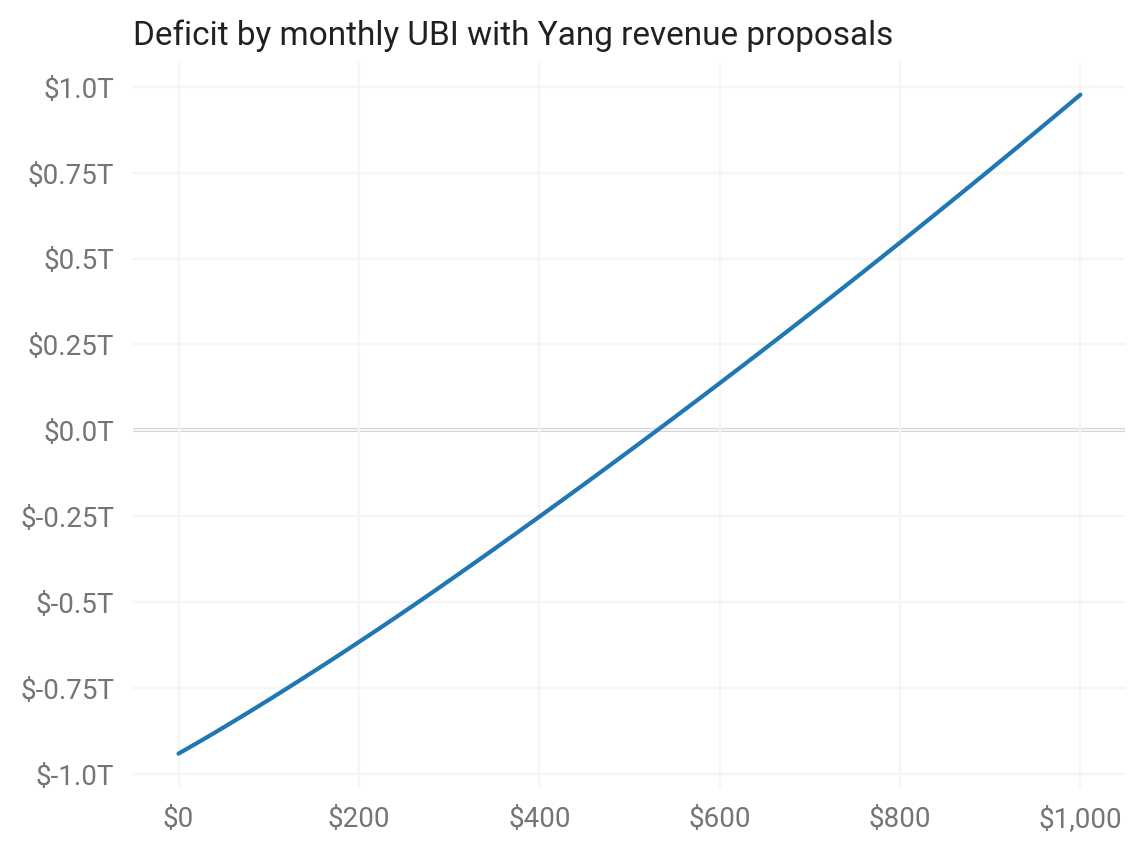

In [21]:
ax = shortfalls_ben.sort_values('ubi').plot('ubi_monthly', 'shortfall')
plt.title('Deficit by monthly UBI with Yang revenue proposals', loc='left')
sns.despine(left=True, bottom=True)
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(x / 1e12) + 'T'))
ax.grid(color=GRID_COLOR)
ax.legend_.remove()
ax.axhline(0, color='lightgray', zorder=-1)
plt.xlabel('')
plt.show()

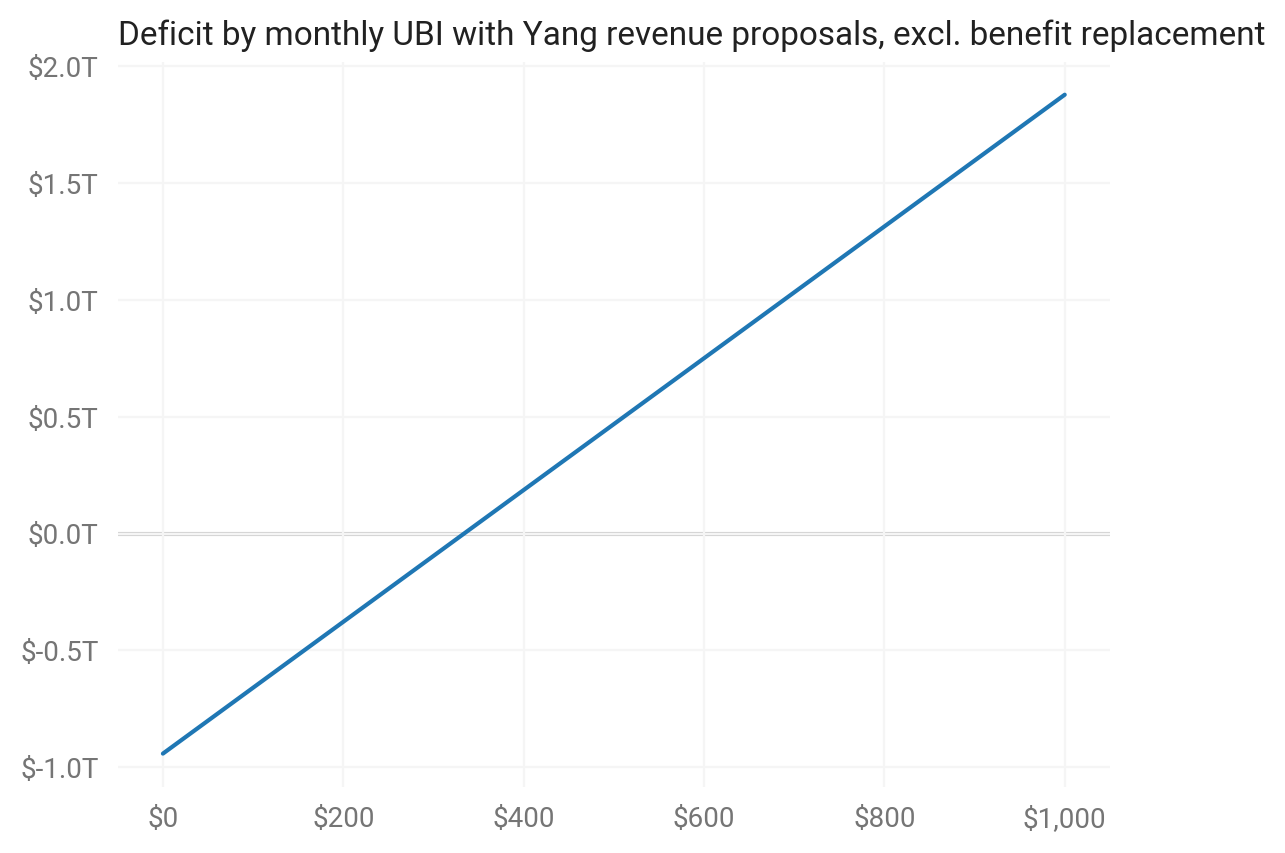

In [22]:
ax = shortfalls_noben.sort_values('ubi').plot('ubi_monthly', 'shortfall')
plt.title('Deficit by monthly UBI with Yang revenue proposals, excl. benefit replacement', loc='left')
sns.despine(left=True, bottom=True)
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(x / 1e12) + 'T'))
ax.grid(color=GRID_COLOR)
ax.legend_.remove()
ax.axhline(0, color='lightgray', zorder=-1)
plt.xlabel('')
plt.show()

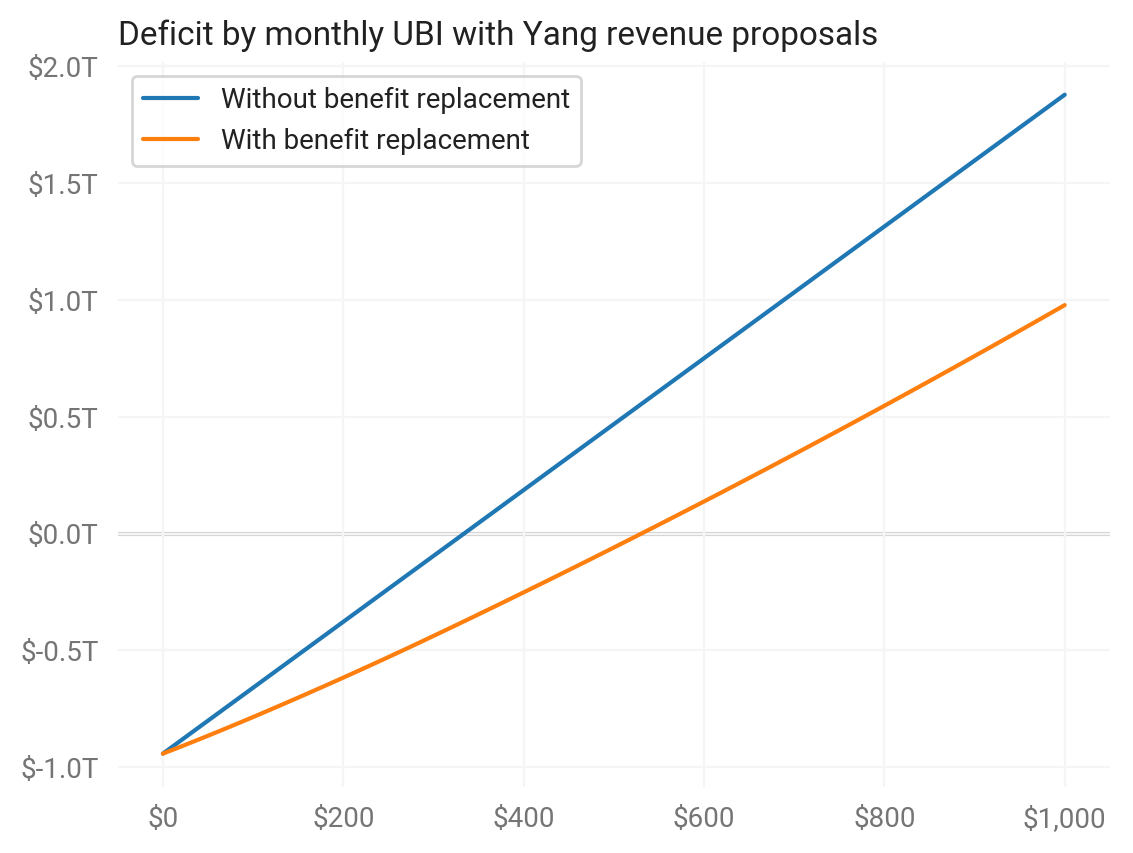

In [23]:
ax = shortfalls_noben.sort_values('ubi').plot('ubi_monthly', 'shortfall')
shortfalls_ben.sort_values('ubi').plot('ubi_monthly', 'shortfall', ax=ax)
plt.title('Deficit by monthly UBI with Yang revenue proposals', loc='left')
sns.despine(left=True, bottom=True)
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(x / 1e12) + 'T'))
ax.grid(color=GRID_COLOR)
ax.legend(['Without benefit replacement', 'With benefit replacement'])
ax.axhline(0, color='lightgray', zorder=-1)
plt.xlabel('')
plt.show()